Depreciated.

This script contains some of the work in progress along the way to the correct realisation of things like the LDOS and spectral function.

Checking normalisation of eigenvectors:
All probabilities are correctly normalized within the tolerance of 1.0e-15.
Checking normalisation of probabilities:
All probabilities are correctly normalized within the tolerance of 1.0e-15.


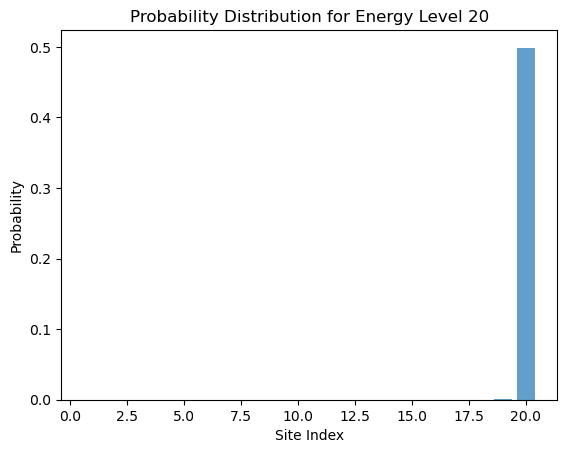

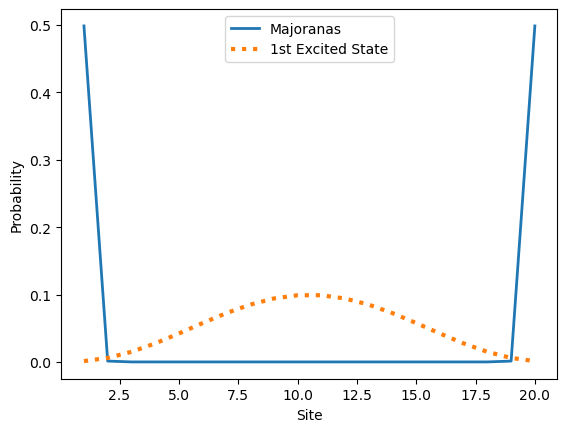

In [1]:
using LinearAlgebra
using PyPlot
using Plots


# # ****************************** Sec 1 ******************************
# # Setting up the BdG matrix and solving for the eigenvalues and eigenvectors

function create_normal_hamiltonian(N::Int, t::Float64, mu::Float64)
    """
    Constructs the normal-state Hamiltonian H_0 of the Kitaev chain.

    Parameters:
    N  -- Number of lattice sites
    t  -- Hopping term
    mu -- Chemical potential
    
    Returns:
    H0 -- NxN matrix representing the normal-state Hamiltonian
    """
    H0 = ComplexF64[0.0 + 0im for _ in 1:N, _ in 1:N]
    # H0 = zeros(Float64, N, N)

    for i in 1:N
        H0[i, i] = -mu + 0im
    end

    for i in 1:N-1
        H0[i, i+1] = -t + 0im
        H0[i+1, i] = -t + 0im
    end

    return H0
end

function create_pairing_matrix(N::Int, Delta::Float64)
    """
    Constructs the pairing matrix Delta for the Kitaev chain.

    Parameters:
    N  -- Number of lattice sites
    Delta  -- Superconducting pairing term
    
    Returns:
    pairing_matrix -- NxN matrix representing the pairing interactions
    """
    pairing_matrix = ComplexF64[0.0 + 0im for _ in 1:N, _ in 1:N]
    # pairing_matrix = zeros(Float64, N, N)

    for i in 1:N-1
        pairing_matrix[i, i+1] = Delta + 0im
        pairing_matrix[i+1, i] = -Delta + 0im
    end

    return pairing_matrix
end

function create_bdg_hamiltonian(N::Int, H0::Matrix{ComplexF64}, Delta::Matrix{ComplexF64})
    """
    Constructs the 2N x 2N BdG Hamiltonian matrix using H_0 and Delta.

    Parameters:
    N  -- Number of lattice sites
    H0 -- NxN normal-state Hamiltonian matrix (hopping and chemical potential)
    Delta  -- NxN pairing matrix
    
    Returns:
    BdG Hamiltonian -- 2Nx2N matrix representing the BdG Hamiltonian
    """
    BdG = ComplexF64[0.0 + 0im for _ in 1:2*N, _ in 1:2*N]
    # BdG = zeros(Float64, 2*N, 2*N)

    BdG[1:N, 1:N] = H0
    BdG[N+1:end, N+1:end] = -H0'
    BdG[1:N, N+1:end] = Delta
    BdG[N+1:end, 1:N] = Delta'

    return BdG
end

function solve_bdg_hamiltonian(BdG::Matrix{ComplexF64})
    """
    Returns the BdG Hamiltonian eigenvalues and eigenvectors.

    Parameters:
    BdG -- 2Nx2N BdG Hamiltonian matrix
    
    Returns:
    eigenvalues -- Vector of eigenvalues
    eigenvectors -- Matrix of eigenvectors
    """
    eigenvalues, eigenvectors = eigen(BdG)
    return eigenvalues, eigenvectors
end

function check_eigenvectors_normalisation(eigenvectors::Matrix{ComplexF64}, tolerance::Float64)
    """
    Checks if the eigenvectors are normalized, i.e., each eigenvector should have a norm of 1.

    Parameters:
    eigenvectors -- Matrix of eigenvectors (2N x 2N)
    tolerance -- Float value for allowed tolerance in the normalization check
    
    Returns:
    A summary message indicating whether all eigenvectors are normalized,
    and details of any that are not normalized.
    """
    N = size(eigenvectors, 1)  # Number of eigenvectors
    results = []

    for i in 1:N
        norm_value = norm(eigenvectors[:, i])
        # # print the values of eigenvector norms if you want
        # println("Energy levels: $(i) has norm: $norm_value")

        if abs(norm_value - 1) > tolerance
            push!(results, (i, norm_value))
        end
    end

    println("Checking normalisation of eigenvectors:")
    if isempty(results)
        println("All probabilities are correctly normalized within the tolerance of $tolerance.")
    else
        println("The following eigenvectors are not normalized:")
        for (index, norm_val) in results
            println("Eigenvector $index: Norm = $norm_val")
        end
    end
end


# # ****************************** Sec 2 ******************************
# # Calculating probability distributions over sites and checking normalisation

function calculate_probability_distributions_bdg(eigenvectors::Matrix{ComplexF64})
    """
    Calculates the probability distributions of site occupancy from the eigenvectors using the BdG formalism.

    Returns:
    probabilities -- 2D array where each row corresponds to a site and each column corresponds to an energy level
    """
    N = size(eigenvectors, 1) ÷ 2  # Number of sites
    probabilities = zeros(Float64, N, size(eigenvectors, 2))

    for i in 1:size(eigenvectors, 2)  # Iterate over energy levels
        for n in 1:N  # Iterate over sites
            u_n_i = eigenvectors[n, i]  # Particle component
            v_n_i = eigenvectors[n+N, i]  # Hole component
            probabilities[n, i] = 0.5 * (abs(u_n_i)^2 + abs(v_n_i)^2)
        end
    end
    return probabilities
end

function check_probability_normalisation(probabilities::Matrix{Float64}, N::Int, tolerance::Float64)
    """
    Checks if the probabilities are correctly normalized for each energy level
    within a specified tolerance.
    
    Parameters:
    probabilities -- Nx(2N) matrix of probabilities
    N -- Number of lattice sites
    tolerance -- Float value representing the acceptable deviation from 1.0
    
    Returns:
    nothing; prints the result of the normalization check.
    """
    unnormalized_pairs = []

    for n in 0:(N-1) 
        total_probability = sum(probabilities[:, N - n] + probabilities[:, N + 1 + n])
        # # print the values of probability sums if you want
        # println("Energy levels: $(N - n) and $(N + 1 + n) -> Sum: $total_probability")
        
        if abs(total_probability - 1.0) > tolerance
            push!(unnormalized_pairs, (N - n, N + 1 + n))
        end
    end

    println("Checking normalisation of probabilities:")
    if isempty(unnormalized_pairs)
        println("All probabilities are correctly normalized within the tolerance of $tolerance.")
    else
        println("The following pairs do not sum to 1 within the tolerance of $tolerance:")
        for (i, j) in unnormalized_pairs
            println("Energy levels: $i and $j")
        end
    end
end



# # ****************************** Sec 3 ******************************
# # Plotting the probability distributions of one eigenstate for a single parameter set

function plot_probability_distribution(probabilities::Matrix{Float64}, energy_level::Int, N::Int)
    """
    Plots the probability distribution of all N sites for a specified energy level.
    """
    if energy_level < 1 || energy_level > 2*N
        error("Energy level must be between 1 and $(2*N).")
    end

    sites = 1:N
    close()
        # plot(sites, probabilities[:, energy_level], lw=3)
        PyPlot.bar(sites, probabilities[:, energy_level], alpha=0.7)
    title("Probability Distribution for Energy Level $energy_level")
    xlabel("Site Index")
    ylabel("Probability")
    
    display(gcf())

end

function plot_paired_probability_distributions(probabilities::Matrix{Float64}, N::Int)
    
    sites = 1:N
    close()
        # Plotting Majorana modes
        PyPlot.plot(sites, probabilities[:, N] + probabilities[:, N + 1], label="Majoranas", lw=2)
        # println("Total probability of Majoranas: $(sum(probabilities[:, N] + probabilities[:, N + 1]))")

        # Plotting first excited state
        PyPlot.plot(sites, probabilities[:, N - 1] + probabilities[:, N + 2], label="1st Excited State", linestyle=":", lw=3)
        # println("Total probability of first excited state: $(sum(probabilities[:, N - 1] + probabilities[:, N + 2]))")

        xlabel("Site")
        ylabel("Probability")
        legend()
    display(gcf())
end



# #****************************** Sec 4 ******************************
# # Example usage code for functions in Sec 1-3

# Parameters
N = 20
t = 1.0
mu = 0.1
Delta = t

# Create matrices and find eigenvalues/eigenvectors
H0 = create_normal_hamiltonian(N, t, mu)
Delta_matrix = create_pairing_matrix(N, Delta)
BdG = create_bdg_hamiltonian(N, H0, Delta_matrix)

# # BdG looks good :)
# println("BdG matrix:")
# println(size(BdG))
# println(BdG)

eigenvalues, eigenvectors = solve_bdg_hamiltonian(BdG)

probabilities = calculate_probability_distributions_bdg(eigenvectors)


# # These print statements can be used to check that the inital setup and eigenvalue 
# # calculations are working in the same way as the Python code
# println("Eigenvalues of the BdG Hamiltonian:")
# println(size(eigenvalues))
# println(eigenvalues)

# println("Eigenvectors")
# println("eigenvectors type: ", typeof(eigenvectors))
# println("eigenvectors size: ", size(eigenvectors))
# println(eigenvectors)

# println("Probability Distributions: ")
# println(probabilities)
# println(size(probabilities))

# Check normalisations
check_eigenvectors_normalisation(eigenvectors, 1e-15)

check_probability_normalisation(probabilities, N, 1e-15)

# Plot single half-energy level distribution
plot_probability_distribution(probabilities, 20, N)

plot_paired_probability_distributions(probabilities, N)



In [2]:
"""
Functional, based on plotting functions working, but not sure why nothing is printing
"""
function eigenvalue_finder_with_mu_t_ratio(N::Int, x_values::Vector{Float64}, ref_value::Float64, ref_param::String; Delta::Float64=1.0)
    """
    Computes the eigenvalues for a list of values of x = mu/t, given a fixed value of either mu or t.

    Parameters:
    N           -- Int: Number of atomic sites in the chain
    x_values    -- Vector{Float64}: List of values for the ratio mu/t (x)
    ref_value   -- Float64: Fixed reference value for either mu or t
    ref_param   -- String: The name of the parameter that is fixed: either 'mu' or 't'
    Delta       -- Float64: The value of the pairing constant (default is 1.0)

    Returns:
    results     -- Vector of dictionaries containing the results for each x
    """

    results::Vector{Dict{String, Any}} = []

    for x in x_values
        if ref_param == "t"
            t = ref_value
            mu = x * t
        elseif ref_param == "mu"
            mu = ref_value
            t = mu / x
        else
            throw(ArgumentError("ref_param must be either 'mu' or 't'"))
        end

        H0 = create_normal_hamiltonian(N, t, mu)
        pairing_matrix = create_pairing_matrix(N, Delta)
        BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)
        eigenvalues, eigenvectors = solve_bdg_hamiltonian(BdG)
        probabilities = calculate_probability_distributions_bdg(eigenvectors)

        # # make new versions fo thee functions to integrate better into this loop
        # check_eigenvectors_normalisation(eigenvectors, 1e-15)
        # check_probability_normalisation(probabilities, N, 1e-15)
        

        push!(results, Dict(
            "mu_t_ratio" => x,
            "t" => t,
            "mu" => mu,
            "eigenvalues" => eigenvalues,
            "eigenvectors" => eigenvectors,
            "probabilities" => probabilities
        ))
    end

    return results
end

function calculate_paired_probabilities(results::Vector{Dict{String, Any}})
    """
    Calculates the paired probabilities for each result in the provided array.
    
    Parameters:
    results -- Array of dictionaries containing eigenvalues, eigenvectors, and probabilities
    
    Returns:
    Nothing; the results are modified in place to include paired probabilities.
    """
    for result in results
        probabilities = result["probabilities"]
        eigenvectors = result["eigenvectors"]
        N = size(probabilities, 1)  # Number of sites
        
        # Initialize paired probabilities array
        paired_probabilities = zeros(Float64, N)
        paired_eigenvectors = zeros(Float64, N)

        # Calculate paired probabilities for Majorana modes (last two states)
        for n in 1:N
            paired_probabilities[n] = probabilities[n, N] + probabilities[n, N + 1]
            paired_eigenvectors[n] = eigenvectors[n, N] + eigenvectors[n, N + 1]
        end
        
        # Store paired probabilities in the result
        result["paired_probabilities"] = paired_probabilities
        result["paired_eigenvectors"] = paired_eigenvectors
    end
end

function calculate_paired_eigenvectors(results::Vector{Dict{String, Any}})
    """
    Calculates the paired eigenvectors for each result in the provided array. The eigenvectors are paired such that
    the original 2Nx2N eigenvector matrix is reduced to an NxN matrix by pairing the rows and columns.
    
    Parameters:
    results -- Array of dictionaries containing eigenvalues, eigenvectors, and probabilities
    
    Returns:
    Nothing; the results are modified in place to include paired eigenvectors as NxN matrices.
    """
    for result in results
        eigenvectors = result["eigenvectors"]  # This should be a 2Nx2N matrix
        N = size(eigenvectors, 1) ÷ 2  # Number of sites
        
        # Initialize paired_eigenvectors as an NxN matrix of Complex{Float64}
        paired_eigenvectors = zeros(ComplexF64, N, N)

        # Pair the rows and columns to reduce the 2Nx2N eigenvector matrix to an NxN matrix
        for i in 1:N
            for j in 1:N
                # Pair elements of rows and columns
                paired_eigenvectors[i, j] = eigenvectors[i, j] + eigenvectors[N + i, N + j]
            end
        end

        # Store paired eigenvectors in the result
        result["paired_eigenvectors"] = paired_eigenvectors
    end
end



mu_t_ratio_values = collect(range(0.0, stop=3.0, length=30))
# println("values list type: ", typeof(mu_t_ratio_values))
ref_value = t
N = 50
# Delta = 1.0
ref_param="t"

results = eigenvalue_finder_with_mu_t_ratio(N, mu_t_ratio_values, ref_value, ref_param)
# println(results)
# println(typeof(results))

calculate_paired_probabilities(results)
# println(results)

calculate_paired_eigenvectors(results)

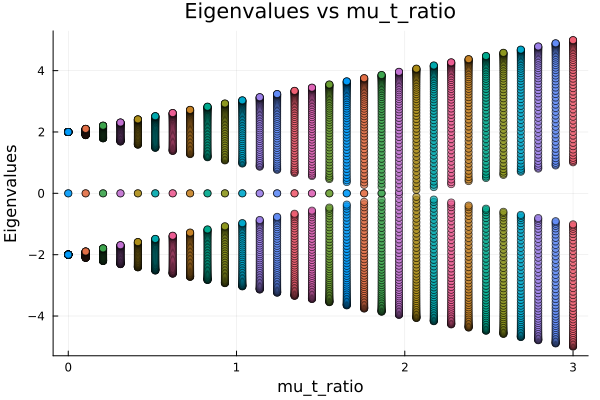

mu/t = 0.0
Paired Probabilities: [0.49999999999999983, 4.7037373450887395e-35, 9.429562804301171e-33, 1.4583472456261581e-35, 3.0551950223131688e-34, 1.3728794625311775e-35, 3.861444928111636e-33, 8.750630239693123e-36, 6.97992668195619e-33, 1.3792226395899776e-36, 2.0801281072734587e-33, 2.9383022087181156e-35, 4.814431773291109e-33, 6.657964924896146e-36, 1.4329128635522423e-33, 8.146659052357842e-36, 6.950076278058258e-33, 1.2441664404185846e-35, 3.324015919509634e-33, 2.3557417178789362e-36, 2.4317519283384468e-33, 2.3790829562749446e-36, 4.089080993915185e-33, 1.7170509098480314e-35, 1.0137900699490805e-33, 4.028693498880413e-36, 2.3365485636736986e-33, 8.508306216588125e-36, 4.332389767066704e-33, 1.314811430169e-35, 1.3422224443470702e-33, 1.7293251557128692e-36, 2.6256521541029064e-33, 4.0093787550603605e-37, 1.50388979994209e-33, 1.2268170326617112e-36, 4.683245345888972e-34, 7.948995288776198e-36, 1.2341143335546203e-32, 4.033024756169124e-36, 1.510654080943834e-32, 3.7617231

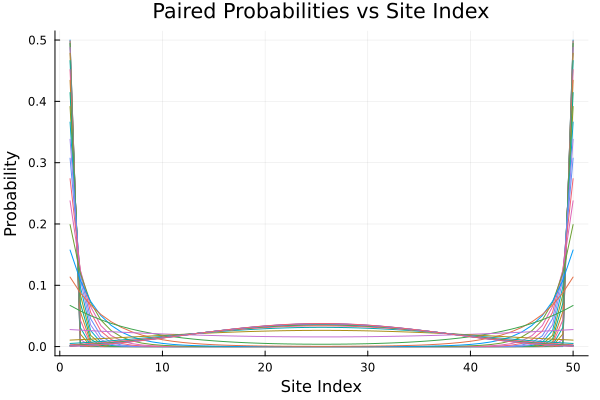

In [3]:
# Function to plot eigenvalues as a function of mu_t_ratio
function plot_eigenvalues(results::Vector{Dict{String, Any}}, variable::String = "mu_t_ratio", eigenvalues_column::String = "eigenvalues")
    """
    Plots eigenvalues as a function of mu/t ratio or t.

    Parameters:
    results             -- Vector of dictionaries containing results.
    variable            -- String: The variable used for the x-axis (mu_t_ratio).
    eigenvalues_column  -- String: The column containing eigenvalues.
    """
    close()
        plt = Plots.scatter(legend=false, xlabel=variable, ylabel="Eigenvalues", title="Eigenvalues vs $variable", grid=true)

        for result in results
            x_value = result[variable]
            eigenvalues = result[eigenvalues_column]

            scatter!(fill(x_value, length(eigenvalues)), eigenvalues, marker=:circle, ms=4, alpha=0.7)
        end

    display(plt)
end

# # Function to plot paired probabilities for each mu/t value
function plot_paired_probabilities(results::Vector{Dict{String, Any}}, N::Int)
    """
    Plots paired probabilities for each mu/t_ratio on the same plot as line plots.

    Parameters:
    results -- Vector of dictionaries containing mu_t_ratio and paired_probabilities.
    N       -- Int: Number of sites in the chain.
    """  
    close()

        plt = Plots.plot(legend=false, xlabel="Site Index", ylabel="Probability", title="Paired Probabilities vs Site Index", grid=true)

        for result in results
            mu_t_value = result["mu_t_ratio"]
            paired_probabilities = result["paired_probabilities"]

            # println("mu/t = $mu_t_value")
            # println("Paired Probabilities: ", paired_probabilities)

            plot!(1:N, paired_probabilities, label="mu/t = $mu_t_value")

        end
    display(plt)
end

# Plot eigenvalues
plot_eigenvalues(results, "mu_t_ratio", "eigenvalues")

plot_paired_probabilities(results, N)

In [4]:
using Plots
using DataFrame
# Function to calculate the band structure for the Kitaev chain model
# currently not working - issue with the logic handling the generality to take any variable as the parameter changing.
# The basic function below this works for mu/t.
function calc_band_structure(variable_array, delta, N_k, variable_name="t", ref_param="t", ref_value=1.0)
    results = DataFrame(variable_name=Float64[], E_plus=Float64[], E_minus=Float64[])
    t_vals = Float64[]
    mu_vals = Float64[]

    # Set up t_vals and mu_vals based on variable_name
    if variable_name == "t"
        t_vals = variable_array
        mu_vals .= ref_value
    elseif variable_name == "mu"
        mu_vals = variable_array
        t_vals .= ref_value
    elseif variable_name == "mu_t_ratio"
        for ratio in variable_array
            if ref_param == "t"
                t = ref_value
                mu = ratio * t
            elseif ref_param == "mu"
                mu = ref_value
                t = mu / ratio
            end
            push!(t_vals, t)
            push!(mu_vals, mu)
        end
    end

    println("t_vals: ", t_vals)
    println("mu_vals: ", mu_vals)

    k_vals = range(-π, π, length=N_k)

    # Calculate E_plus and E_minus for each (t, mu) pair and k-value
    for (idx, (t, mu)) in enumerate(zip(t_vals, mu_vals))
        E_plus = zeros(Float64, N_k)
        E_minus = zeros(Float64, N_k)
        
        for (i, k) in enumerate(k_vals)
            E_plus[i] = sqrt((mu + 2 * t * cos(k))^2 + (2 * delta * sin(k))^2)
            E_minus[i] = -E_plus[i]

            # Append each result as a row in DataFrame
            push!(results, (variable_name => variable_array[idx], "E_plus" => E_plus[i], "E_minus" => E_minus[i]))
        end
    end
    return results
end


# Function to calculate the band structure for the Kitaev chain model, only handling mu_t_ratio
function calc_band_structure_basic(mu_t_ratio_array, delta, N_k, t=1.0)

    results = DataFrame(mu_t_ratio=Float64[], E_plus=Float64[], E_minus=Float64[])
    
    k_vals = range(-pi, pi, length=N_k)

    for mu_t_ratio in mu_t_ratio_array
        mu = mu_t_ratio * t

        E_plus = zeros(Float64, N_k)
        E_minus = zeros(Float64, N_k)
        
        for (i, k) in enumerate(k_vals)
            E_plus[i] = sqrt((mu + 2 * t * cos(k))^2 + (2 * delta * sin(k))^2)
            E_minus[i] = -E_plus[i]

            push!(results, (mu_t_ratio, E_plus[i], E_minus[i]))
        end
    end
    return results
end


# Function to plot the band structure
function plot_band_structure(df, param_name="t")
    unique_params = unique(df[!, param_name])
    n_plots = length(unique_params)
    n_cols = min(n_plots, 5)
    n_rows = ceil(Int, n_plots / n_cols)
    
    plot_layout = @layout [Plots.grid(n_rows, n_cols)]
    plot_arr = []

    # Generate subplots for each unique parameter value
    for param_val in unique_params
        df_param = filter(row -> row[param_name] == param_val, df)
        
        k_vals = range(-π, π, length=size(df_param, 1))
        E_plus = df_param[!, "E_plus"]
        E_minus = df_param[!, "E_minus"]

        p = Plots.plot(k_vals, E_plus, label="E+", color="blue", xlabel="k (momentum)", ylabel="Energy", ylim=(-5, 5), title="Band Structure for $param_name = $param_val", legend=:topright, grid=true)
        plot!(k_vals, E_minus, label="E-", color="red")
        
        push!(plot_arr, p)
    end

    # Plot all subplots together
    Plots.plot(plot_arr..., layout=plot_layout, size=(1000, 500 * n_rows))
end




# Usage
variable_array = mu_t_ratio_values # collect(range(0.0, stop=3.0, length=30))
delta = 1.0
N_k = 200

variable_name = "mu_t_ratio"
reference_param = "t"
reference_value = 1.0
# results_mu_t_ratio = calc_band_structure(variable_array, delta, N_k, variable_name, reference_param, reference_value)\

results_mu_t_ratio = calc_band_structure_basic(variable_array, delta, N_k, reference_value)

println("got to here")

plot_band_structure(results_mu_t_ratio, variable_name)

ArgumentError: ArgumentError: Package DataFrame not found in current path.
- Run `import Pkg; Pkg.add("DataFrame")` to install the DataFrame package.

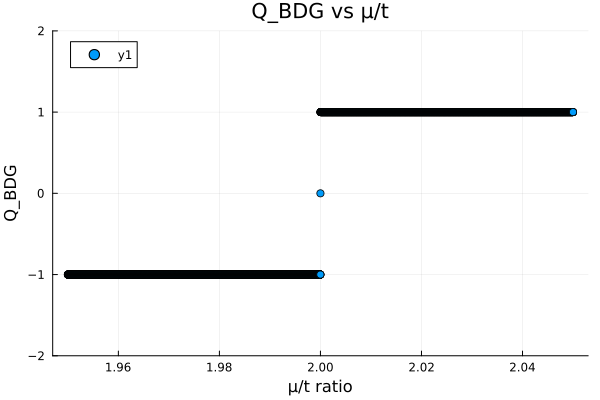

In [5]:
using LinearAlgebra
using SkewLinearAlgebra
using Plots

# Generate a range of μ values
mu_list = 1.95:0.00001:2.05 # mu_t_ratio_values # -4:0.1:4
num = length(mu_list)
Q_BDG_list = zeros(Float64, num)

function find_pfaffian_of(BDG_matrix)
    # Convert the matrix to an antisymmetric form to compute the Pfaffian
    unitary_matrix = [1  -1im; 1 1im]
    unitary_matrix_dagger = adjoint(unitary_matrix)
    antisymmetric_matrix = (1/2) * (unitary_matrix_dagger * BDG_matrix * unitary_matrix)

    return pfaffian(antisymmetric_matrix)
end

function find_Q_BDG(mu, t)
    """
    Compute Q_BDG, the topological invariant, for given μ and t
    following the procedure outlined.
    """

    # Define the Hamiltonian in k-space for k=0 and k=π
    hamiltonian_at_0 = [-2 * t - mu 0; 0 2 * t + mu]
    hamiltonian_at_pi = [2 * t - mu 0; 0 -2 * t + mu]

    # Find the Pfaffians of the Hamiltonians at k=0 and k=π
    pf_at_0 = find_pfaffian_of(1im * hamiltonian_at_0)
    pf_at_pi = find_pfaffian_of(1im * hamiltonian_at_pi)

    # Calculate Q_BDG
    Q_BDG = sign(pf_at_0 * pf_at_pi)
    return Q_BDG
end

# Calculate Q_BDG values for each μ
for i in 1:num
    Q_BDG_list[i] = find_Q_BDG(mu_list[i], 1.0)
end

# Plotting the results
Plots.scatter(mu_list, Q_BDG_list, xlabel="μ/t ratio", ylabel="Q_BDG", title="Q_BDG vs μ/t", ylim=(-2, 2), grid=true)


In [6]:

# # Function to calculate the Pfaffian
# function create_H_BdG_tilde(H0::Matrix{ComplexF64}, Delta_matrix::Matrix{ComplexF64}, N::Int)

#     H_BdG_tilde = zeros(ComplexF64, 2*N, 2*N)

#     H_BdG_tilde[1:N, 1:N] = H0 - conj(H0) + (Delta_matrix - conj(Delta_matrix))
#     H_BdG_tilde[N+1:end, N+1:end] = H0 - conj(H0) - (Delta_matrix - conj(Delta_matrix))
#     H_BdG_tilde[1:N, N+1:end] = im * (-(H0 + conj(H0)) + Delta_matrix + conj(Delta_matrix))
#     H_BdG_tilde[N+1:end, 1:N] = im * ((H0 + conj(H0)) + Delta_matrix + conj(Delta_matrix))

#     # println("H_BdG_tilde:")
#     # println(H_BdG_tilde)

#     if H_BdG_tilde != -(transpose(H_BdG_tilde))
#         throw(ArgumentError("Matrix must be antisymmetric."))
#     end

#     return H_BdG_tilde
    
# end





# # # Parameters
# # N = 2
# # t = 1.0
# # mu = 0.1
# # Delta = t

# # # Create matrices and find eigenvalues/eigenvectors
# # H0 = create_normal_hamiltonian(N, t, mu)
# # Delta_matrix = create_pairing_matrix(N, Delta)
# # BdG = create_bdg_hamiltonian(N, H0, Delta_matrix)



# H_BdG_tilde = create_H_BdG_tilde(H0, Delta_matrix, N)



# using Combinatorics

# function permutation_sign(sigma::Vector{Int})
#     inversions = 0
#     n = length(sigma)
#     for i in 1:n
#         for j in (i+1):n
#             if sigma[i] > sigma[j]
#                 inversions += 1
#             end
#         end
#     end
#     return (-1)^inversions
# end

# # Function to compute the Pfaffian of a skew-symmetric matrix A
# function pfaffian(A::Matrix{ComplexF64})#AbstractMatrix{T}) where T
#     n = size(A, 1) ÷ 2  # n is half the size of the matrix
#     println(n)

#     # Ensure the matrix is skew-symmetric and of even size
#     if size(A, 1) != size(A, 2) || size(A, 1) % 2 != 0 || A != -(transpose(A))
#         throw(ArgumentError("Matrix must be skew-symmetric and of even size"))
#     end

#     # Calculate the Pfaffian using the provided definition
#     pf = 0.0
#     for sigma in permutations(1:2*n)
#         # Calculate the product for pairs
#         product = 1.0
#         valid = true
        
#         for i in 1:n
#             # Access the appropriate elements based on the permutation sigma
#             product *= A[sigma[2*i-1], sigma[2*i]]
#         end
        
#         # If valid, calculate the contribution
#         pf += permutation_sign(sigma) * product
#     end

#     return pf / factorial(n)
# end


# """
# # attempt at using my own function
# # this works, but not sure it returns the correct values
# # it is not optimised for speed given the skew-symmetry of the matrix so is VERY slow for N>6
# """

# # # Calculate the Pfaffian
# # pf = pfaffian(H_BdG_tilde)

# # # Print the result
# # println("N = ", N)
# # println("Pfaffian: ", pf)




# # # """
# # # This is an attempt to import the julia version of the Pfapack functions
# # # """
# # include("/Users/Will/Documents/FINAL_PROJECT/external_work/pfaffian_calc/Pfaffian_jl/Pfaffian.jl")
# # using .PfafModule

# # pf = Pfaffian(H_BdG_tilde)
# # println("Pfaffian from package: ", pf)





# # """
# # This is using PyCall to import the python version of function and use it in the julia script
# # """
# using PyCall
# pushfirst!(PyVector(pyimport("sys")."path"), "/Users/Will/Documents/FINAL_PROJECT/external_work/pfaffian_calc/pfapack/python")
# pfaffian = pyimport("pfaffian")

# pf_result = pfaffian.pfaffian_householder(H_BdG_tilde)

# # Print the result from Python
# println("Result from Python: ", pf_result)

LDOS

------------------------
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
type of paired eig: Matrix{ComplexF64}
size of paired eig: (50, 50)
type of eig: Matrix{ComplexF64}
size of eig: (100, 100)


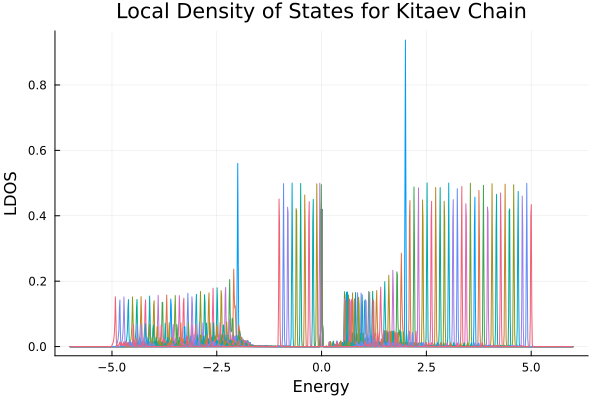

In [7]:
function calculate_ldos_kitaev_chain(eigenvalues::Vector{Float64}, eigenvectors::Matrix{Complex{Float64}}, site_index::Int, energy_range::Vector{Float64}, N::Int, delta::Float64=0.01)
    """
    Calculate the Local Density of States (LDOS) for the Kitaev chain at a specific site index.
    
    Args:
        eigenvalues: Eigenvalues of the BdG Hamiltonian (1D array).
        eigenvectors: Eigenvectors of the BdG Hamiltonian (2D array).
        site_index: Integer, the index of the site where LDOS is calculated.
        energy_range: Array of energies at which to calculate LDOS (1D array).
        delta: Width of the Gaussian used to approximate the delta function (default is 0.01).
    
    Returns:
        ldos: Local density of states at the specified site index (1D array).
    """
    ldos = zeros(Float64, length(energy_range))

    for n in 1:length(eigenvalues)
        u_i = eigenvectors[n, site_index]
        v_i = eigenvectors[n, N + site_index]
        wavefunction = eigenvectors[n, site_index] + eigenvectors[n, N + site_index]
        energy = eigenvalues[n]


        # ldos .+= abs(wavefunction)^2 * exp.(-(energy_range .- energy).^2 / (2 * delta^2))

        ldos .+= (abs(u_i)^2 + abs(v_i)^2) * exp.(-(energy_range .- energy).^2 / (2 * delta^2))
    end

    return ldos
end


# initial
# function calculate_ldos_for_all(results::Vector{Dict{String, Any}}, energy_range::Vector{Float64}, delta::Float64=0.01)
#     """
#     Calculate the Local Density of States (LDOS) for the Kitaev chain for all entries in the results object.
    
#     Args:
#         results: Array of dictionaries containing eigenvalues, eigenvectors, and probabilities.
#         energy_range: Array of energies at which to calculate LDOS (1D array).
#         delta: Width of the Gaussian used to approximate the delta function (default is 0.01).
    
#     Returns:
#         ldos_results: Vector of arrays containing LDOS for each result in the provided array.
#     """
#     ldos_results = Vector{Vector{Float64}}(undef, length(results))

#     for (index, result) in enumerate(results)
#         eigenvalues = result["eigenvalues"]
#         eigenvectors = result["eigenvectors"]
#         N = size(eigenvectors, 2)
#         site_index = 1  # Index of the site for LDOS calculation (1-based indexing in Julia)

#         ldos = zeros(Float64, length(energy_range))

#         for n in 1:length(eigenvalues)
#             wavefunction = eigenvectors[n, site_index] + eigenvectors[n, (N-1) + site_index]
#             energy = eigenvalues[n]

#             ldos .+= abs(wavefunction)^2 * exp.(-(energy_range .- energy).^2 / (2 * delta^2))
#         end

#         ldos_results[index] = ldos
#     end

#     return ldos_results
# end


# # my revised
# function calculate_ldos_for_all(results::Vector{Dict{String, Any}}, energy_range::Vector{Float64}, delta::Float64=0.01)
#     """
#     Calculate the Local Density of States (LDOS) for the Kitaev chain using paired_eigenvectors for all entries in the results object.
    
#     Args:
#         results: Array of dictionaries containing eigenvalues, paired_eigenvectors.
#         energy_range: Array of energies at which to calculate LDOS (1D array).
#         delta: Width of the Gaussian used to approximate the delta function (default is 0.01).
    
#     Returns:
#         ldos_results: Vector of arrays containing LDOS for each result in the provided array.
#     """
#     ldos_results = Vector{Vector{Float64}}(undef, length(results))

#     for (index, result) in enumerate(results)
#         eigenvalues = result["eigenvalues"]
#         paired_eigenvectors = result["paired_eigenvectors"]  # NxN matrix
#         N = size(paired_eigenvectors, 1)  # Number of sites

#         # Initialize the LDOS array
#         ldos = zeros(Float64, length(energy_range))

#         # Loop over each eigenvalue and corresponding eigenvector (each column of paired_eigenvectors)
#         for n in 1:length(eigenvalues)
#             wavefunction = paired_eigenvectors[:, n]  # Get the entire wave function for eigenvalue n
#             energy = eigenvalues[n]

#             # Contribution to the LDOS using the Gaussian approximation
#             ldos .+= abs2.(wavefunction) .* exp.(-(energy_range .- energy).^2 / (2 * delta^2))
#         end

#         # Store the LDOS for this set of results
#         ldos_results[index] = ldos
#     end

#     return ldos_results
# end

# new revised
function calculate_ldos_for_all_params_at_a_site(results::Vector{Dict{String, Any}}, site_index::Int, N::Int, energy_range::Vector{Float64}, delta::Float64=0.01)
    """
    Calculate the Local Density of States (LDOS) for the Kitaev chain for all entries in the results object.
    
    Args:
        results: Array of dictionaries containing eigenvalues, paired eigenvectors, and probabilities.
        energy_range: Array of energies at which to calculate LDOS (1D array).
        delta: Width of the Gaussian used to approximate the delta function (default is 0.01).
    
    Returns:
        ldos_results: Vector of arrays containing LDOS for each result in the provided array.
    """
    ldos_results = Vector{Vector{Float64}}(undef, length(results))

    for (index, result) in enumerate(results)
        eigenvalues = result["eigenvalues"]
        # paired_eigenvectors = result["paired_eigenvectors"] 
        # N = size(paired_eigenvectors, 1) 
        
        ldos = zeros(Float64, length(energy_range))

        # Iterate over each eigenvalue and eigenvector
        for n in 1:length(eigenvalues)
            u_i = eigenvectors[n, site_index]
            v_i = eigenvectors[n, N + site_index]
            wavefunction = eigenvectors[n, site_index] + eigenvectors[n, N + site_index]
            energy = eigenvalues[n]


            # ldos .+= abs(wavefunction)^2 * exp.(-(energy_range .- energy).^2 / (2 * delta^2))

            ldos .+= (abs(u_i)^2 + abs(v_i)^2) * exp.(-(energy_range .- energy).^2 / (2 * delta^2))
        end

        ldos_results[index] = ldos
    end

    return ldos_results
end







using DataFrames



energy_min = -6.0 
energy_max = 6.0
energy_range = collect(range(energy_min, stop=energy_max, length=1000))

println("------------------------")
println(keys(results))

result = results[1]
paired_eigenvectors = result["paired_eigenvectors"]
eigenvectors = result["eigenvectors"]
println("type of paired eig: ", typeof(paired_eigenvectors))
println("size of paired eig: ", size(paired_eigenvectors))
println("type of eig: ", typeof(eigenvectors))
println("size of eig: ", size(eigenvectors))



# Calculate LDOS for all results
ldos_results = calculate_ldos_for_all_params_at_a_site(results, 1, N, energy_range)


function plot_LDOS(ldos_results::Vector{Vector{Float64}}, energy_range::Vector{Float64})#, delta::Float64=0.1)
    close()

        plt = Plots.plot(legend=false, xlabel="Energy", ylabel="LDOS", title="Local Density of States for Kitaev Chain", grid=true)

        for (i, ldos) in enumerate(ldos_results)

            plot!(energy_range, ldos, label="LDOS at Site 1 (mu/t ratio = $(results[i]["mu_t_ratio"]))")

        end
    display(plt)
end




# function plot_ldos_for_results(results::Vector{Dict{String, Any}}, energy_range::Vector{Float64}, delta::Float64=0.01)
#     """
#     Calculate and plot the Local Density of States (LDOS) for the Kitaev chain for all entries in the results object.
    
#     Args:
#         results: Array of dictionaries containing eigenvalues, eigenvectors, and probabilities.
#         energy_range: Array of energies at which to calculate LDOS (1D array).
#         delta: Width of the Gaussian used to approximate the delta function (default is 0.01).
    
#     Returns:
#         Nothing; the LDOS plots are displayed.
#     """
#     ldos_results = Vector{Vector{Float64}}(undef, length(results))

#     for (index, result) in enumerate(results)
#         eigenvalues = result["eigenvalues"]  # Eigenvalues from the result
#         eigenvectors = result["eigenvectors"]  # Eigenvectors from the result
#         N = size(eigenvectors, 2)  # Number of sites
#         site_index = 1  # Index of the site for LDOS calculation (1-based indexing in Julia)

#         ldos = zeros(Float64, length(energy_range))  # Initialize LDOS array

#         # Iterate over each eigenvalue and eigenvector
#         for n in 1:length(eigenvalues)
#             wavefunction = eigenvectors[n, site_index] + eigenvectors[n, N + site_index]  # Wavefunction at site_index
#             energy = eigenvalues[n]

#             # Contribution to the LDOS using Gaussian approximation
#             ldos .+= abs(wavefunction)^2 * exp.(-(energy_range .- energy).^2 / (2 * delta^2))
#         end

#         ldos_results[index] = ldos  # Store the computed LDOS in the results array
#     end

#     # Plotting the LDOS for each mu/t ratio
#     for (i, ldos) in enumerate(ldos_results)
#         plot!(energy_range, ldos, label="LDOS at Site 1 (mu/t ratio = $(results[i]["mu_t_ratio"]))")
#     end

#     title!("Local Density of States for Kitaev Chain")
#     xlabel!("Energy (E)")
#     ylabel!("LDOS")
#     legend!()
#     grid!(true)
#     display(plot)  # Display the plot
# end



plot_LDOS(ldos_results, energy_range)


Below claculations of LDOS and DOS

The LDOS at site $i$ over energy range $E$ is given by this
\begin{equation}
    \begin{split}
        LDOS(i, E) &= \sum_{n} |\psi(x)|^2 \delta(E-E_n) \\
        &= \sum_{n} (|u_n(i)|^2 + |v_n(i)^2|)\delta(E-E_n) \\
        &\approx  \sum_{n} (|u_n(i)|^2 + |v_n(i)^2|) \text{exp} \Big( {\frac{-(E-E_n)^2}{2 \delta^2}} \Big)
    \end{split}
\end{equation}
where we need to extract the particle and hole symmetric parts of $H_{BDG}$ and take the absolute magnitudes squared separately. Also approximating the delta function to a narrow gaussian with parameter $\delta$.

In theory the approximation should become exact in this limit
\begin{equation}
    \begin{split}
        \delta(E-E_n) = \lim_{\delta \to 0} \frac{1}{ \sqrt{2 \pi \delta^2}} \text{exp}\Big ({\frac{-(E-E_n)^2}{2 \delta^2}} \Big)
    \end{split}
\end{equation}

In [8]:

function calculate_ldos_and_total_dos(results::Vector{Dict{String, Any}}, N::Int, energy_range::Vector{Float64}, delta::Float64=0.01)
    """
    Calculate the Local Density of States (LDOS) for each site and the total DOS across all sites
    for all entries in the results object.

    Args:
        results: Array of dictionaries containing eigenvalues, paired_eigenvectors, and probabilities.
        N: Total number of sites in the chain.
        energy_range: Array of energies at which to calculate LDOS (1D array).
        delta: Width of the Gaussian used to approximate the delta function (default is 0.01).

    Returns:
        ldos_results: A Vector of 2D arrays, where each element is an N×length(energy_range) array containing 
                      the LDOS at each site for each energy value, for each result entry.
        total_dos_results: A Vector of 1D arrays, where each element is the total DOS across all sites 
                           for each result entry, summed over all sites at each energy value.
    """
    ldos_results = Vector{Matrix{Float64}}(undef, length(results))
    total_dos_results = Vector{Vector{Float64}}(undef, length(results))

    for (index, result) in enumerate(results)
        eigenvalues = result["eigenvalues"]
        # paired_eigenvectors = result["paired_eigenvectors"]
        eigenvectors = result["eigenvectors"]
        
        # Ensure paired_eigenvectors has the correct dimension
        num_cols = size(eigenvectors, 2)
        has_particle_hole = (num_cols == 2 * N)
        
        # Initialize an N x length(energy_range) matrix for LDOS at each site
        ldos_matrix = zeros(Float64, N, length(energy_range))
        
        # Iterate over each eigenvalue and eigenvector
        for n in 1:length(eigenvalues)
            energy = eigenvalues[n]
            for site_index in 1:N
                # Check the bounds for particle-hole component
                u_i = eigenvectors[n, site_index]
                v_i = has_particle_hole && site_index <= N ? eigenvectors[n, N + site_index] : 0
                ldos_matrix[site_index, :] .+= (abs(u_i)^2 + abs(v_i)^2) * exp.(-(energy_range .- energy).^2 / (2 * delta^2))
            end
        end

        # Store the LDOS matrix for this result entry
        ldos_results[index] = ldos_matrix
        
        # Calculate and store the total DOS by summing the LDOS over all sites
        total_dos_results[index] = sum(ldos_matrix, dims=1)[:]
    end

    return ldos_results, total_dos_results
end





function plot_total_dos(total_dos_results::Vector{Vector{Float64}}, energy_range::Vector{Float64}, results::Vector{Dict{String, Any}})
    """
    Plot the total DOS for each entry in the results object.

    Args:
        total_dos_results: Vector of total DOS arrays (summed LDOS over all sites) for each result entry.
        energy_range: Array of energies at which the total DOS is calculated (1D array).
        results: Array of dictionaries with information about each result entry.
    """
    plt = Plots.plot(legend=true, xlabel="Energy", ylabel="Total DOS", title="Total Density of States for Kitaev Chain", grid=true)

    for (i, dos) in enumerate(total_dos_results)
        plot!(energy_range, dos, label="Total DOS (mu/t = $(results[i]["mu_t_ratio"]))")
    end

    display(plt)
end

using Plots
import FileIO
using Printf


function plot_and_save_total_dos_separately(total_dos_results::Vector{Vector{Float64}}, energy_range::Vector{Float64}, results::Vector{Dict{String, Any}})
    """
    Plot and save the total DOS for each entry in the results object in separate PNG files.

    Args:
        total_dos_results: Vector of total DOS arrays (summed LDOS over all sites) for each result entry.
        energy_range: Array of energies at which the total DOS is calculated (1D array).
        results: Array of dictionaries with information about each result entry.
    """
    # Create the directory if it doesn't exist
    if !isdir("/Users/Will/Documents/FINAL_PROJECT/DOS_plots")
        mkpath("/Users/Will/Documents/FINAL_PROJECT/DOS_plots")
    end

    for (i, dos) in enumerate(total_dos_results)
        formatted_mu_t_ratio = @sprintf("%.2f", results[i]["mu_t_ratio"])
        plt = Plots.plot(energy_range, dos, 
                         xlabel="Energy", 
                         ylabel="Total DOS", 
                         title="Total Density of States (mu/t = $(formatted_mu_t_ratio)", 
                         legend=false, grid=true)
        
        # Save the plot to the DOS_plots folder
        # filename = "/Users/Will/Documents/FINAL_PROJECT/DOS_plots/total_dos_mu_t_$formatted_mu_t_ratio.png"
        # savefig(plt, filename)
        # println("Saved plot to $filename")
        
        # Display plot (optional)
        display(plt)
    end
end






energy_min = -6.0
energy_max = 6.0
energy_range = collect(range(energy_min, stop=energy_max, length=100000))

# delta_1 = 0.001
# delta_2 = 0.001

# # ldos_results_1, total_dos_results_1 = calculate_ldos_and_total_dos(results, N, energy_range, delta_1)
# ldos_results_2, total_dos_results_2 = calculate_ldos_and_total_dos(results, N, energy_range, delta_2)


# # plot_total_dos(total_dos_results_2, energy_range, results)
# # plot_and_save_total_dos_separately(total_dos_results_1, energy_range, results)
# plot_and_save_total_dos_separately(total_dos_results_2, energy_range, results)





100000-element Vector{Float64}:
 -6.0
 -5.999879998799988
 -5.999759997599976
 -5.999639996399964
 -5.999519995199952
 -5.99939999399994
 -5.999279992799928
 -5.999159991599916
 -5.999039990399904
 -5.998919989199892
  ⋮
  5.999039990399904
  5.999159991599916
  5.999279992799928
  5.99939999399994
  5.999519995199952
  5.999639996399964
  5.999759997599976
  5.999879998799988
  6.0

# Spectral Function

In [9]:
"""
Single spectral function calculated - i.e. for 1 set of parameter values at 1 energy
"""

using LinearAlgebra

function greens_function(BdG::Matrix{ComplexF64}, omega::Float64, eta::Float64)
    """
    Computes the Green's function G(omega) for a given BdG Hamiltonian at a specified frequency omega.

    Parameters:
    BdG -- 2N x 2N BdG Hamiltonian matrix
    omega   -- Frequency at which to evaluate the Green's function
    eta   -- Small imaginary part to avoid singularities

    Returns:
    G   -- 2N x 2N matrix representing the Green's function at omega
    """

    G = inv((omega + im * eta) .* I - BdG)
    return G
end

function spectral_function(BdG::Matrix{ComplexF64}, omega::Float64, eta::Float64)
    """
    Computes the spectral function A(omega) for a given BdG Hamiltonian at a specified frequency omega.

    Parameters:
    BdG -- 2N x 2N BdG Hamiltonian matrix
    omega   -- Frequency at which to evaluate the spectral function
    eta   -- Small imaginary part to avoid singularities

    Returns:
    A   -- Scalar value representing the spectral function at omega
    """

    G = greens_function(BdG, omega, eta)

    trace_A = -imag(tr(G)) / π
    A = -imag(G) / π
    return trace_A, A
end

# Usage
N = 25
t = 1.0
mu = 0.1
delta = t
eta = 0.1 # Broadening factor

H0 = create_normal_hamiltonian(N, t, mu)
pairing_matrix = create_pairing_matrix(N, delta)
BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)

# Calculate the spectral function at a specific energy, omega
omega = 0.1
trace_A_omega, A_omega = spectral_function(BdG, omega, eta)
println("Spectral function at omega = $omega: $trace_A_omega")




Spectral function at omega = 0.1: 3.567825739266273


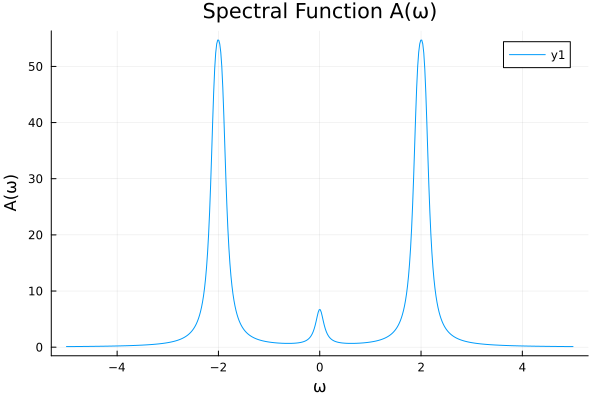

In [10]:
"""
spectral function for single set of parameter values over an energy range
"""

function spectral_function_e_range(N::Int, t::Float64, mu::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64})
    """
    Computes the spectral function A(omega) over a range of energies for a given set of parameter values.

    Parameters:
    N        -- Number of lattice sites
    t        -- Hopping term
    mu        -- Chemical potential
    delta        -- Pairing term
    eta        -- Broadening factor to avoid singularities
    omega_range  -- Vector of energy values (frequencies) to compute the spectral function over

    Returns:
    omega_range  -- The input vector of energy values
    A_values -- Vector of spectral function values corresponding to each omega in omega_range
    """
    H0 = create_normal_hamiltonian(N, t, mu)
    pairing_matrix = create_pairing_matrix(N, delta)
    BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)

    A_values = Float64[]

    for omega in omega_range
        A_omega_trace, A_omega = spectral_function(BdG, omega, eta)
        push!(A_values, A_omega_trace)
    end

    return omega_range, A_values
end

# Usage
omega_range = collect(range(-5.0, 5.0, length=500))

omega_values, A_values = spectral_function_e_range(N, t, mu, delta, eta, omega_range)

Plots.plot(omega_values, A_values, xlabel="ω", ylabel="A(ω)", title="Spectral Function A(ω)")


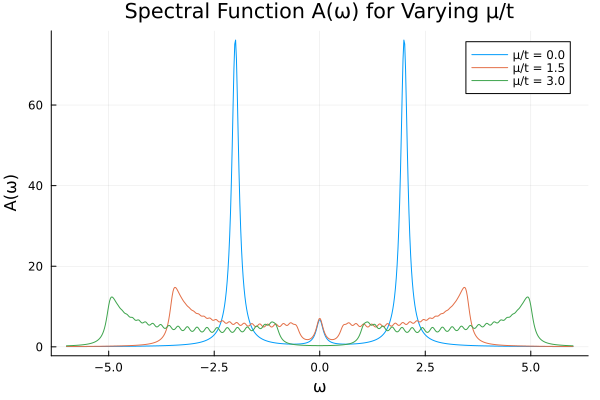

In [11]:
"""
Calculate spectral function for a range of parameter values over an energy range for each
"""

function compute_spectral_function_over_parameters(N::Int, t::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64}, mu_t_range::Vector{Float64})
    """
    Computes the spectral function A(omega) for a range of mu/t parameter values.

    Parameters:
    N          -- Number of lattice sites
    t          -- Hopping term
    Δ          -- Pairing term
    η          -- Broadening factor to avoid singularities
    omega_range    -- Vector of energy values (frequencies) to compute the spectral function over
    mu_t_range -- Vector of mu/t ratios to vary

    Returns:
    results -- A dictionary containing omega_range and A_values for each mu/t ratio
    """
    results = Dict{Float64, Vector{Float64}}()

    # Loop over each mu_t value
    for mu_t in mu_t_range
        mu = mu_t * t

        omega_values, A_values = spectral_function_e_range(N, t, mu, delta, eta, omega_range)
        results[mu_t] = A_values
    end

    return results
end

# Usage
omega_range = collect(range(-6.0, 6.0, length=600))
mu_t_range = collect(range(0.0, 3.0, length=3))

# Compute the spectral function for varying mu/t ratios
spectral_results = compute_spectral_function_over_parameters(N, t, delta, eta, omega_range, mu_t_range)

# Plot the spectral functions for each mu/t ratio
p = Plots.plot(omega_range, spectral_results[mu_t_range[1]], label="μ/t = $(mu_t_range[1])", xlabel="ω", ylabel="A(ω)", title="Spectral Function A(ω) for Varying μ/t", legend=:topright)

for mu_t in mu_t_range[2:end]
    plot!(p, omega_range, spectral_results[mu_t], label="μ/t = $(mu_t)")
end
display(p)

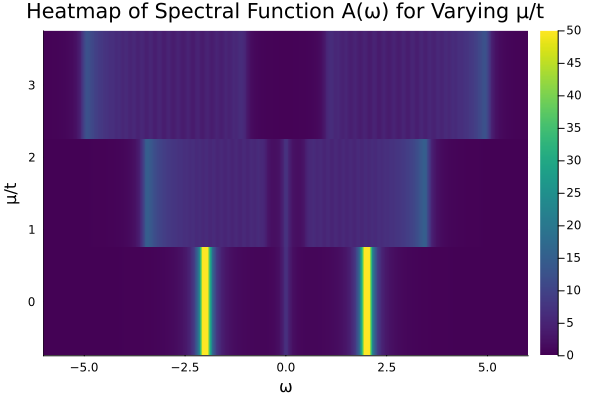

In [12]:
"""
Plotting the calculated spectral functions as a Heatmap
"""

function plot_spectral_function_heatmap(omega_range::Vector{Float64}, mu_t_range::Vector{Float64}, spectral_results::Dict{Float64, Vector{Float64}})
    """
    Plots a heatmap of the spectral function A(omega) for varying mu/t values.

    Parameters:
    omega_range         -- Vector of energy values (frequencies)
    mu_t_range      -- Vector of mu/t ratios used in the computation
    spectral_results -- A dictionary containing spectral function values for each mu/t ratio
    """

    A_matrix = zeros(length(mu_t_range), length(omega_range))

    for (i, mu_t) in enumerate(mu_t_range)
        A_matrix[i, :] = spectral_results[mu_t]
    end

    heatmap(omega_range, mu_t_range, A_matrix,
            xlabel="ω",
            ylabel="μ/t",
            title="Heatmap of Spectral Function A(ω) for Varying μ/t",
            color=:viridis,
            clims=(0, 50),#maximum(A_matrix)), # adjust colour limits
            colorbar=true)
end


plot_spectral_function_heatmap(omega_range, mu_t_range, spectral_results)


In [13]:
using LinearAlgebra
using Plots

function greens_function_total(BdG::Matrix{ComplexF64}, omega::Float64, eta::Float64)
    """
    Computes the total Green's function G(omega) for a given BdG Hamiltonian at a specified frequency omega,
    including both particle and hole contributions.
    """
    G = inv((omega + im * eta) * I - BdG)
    return G
end

function spectral_function_total(BdG::Matrix{ComplexF64}, omega::Float64, eta::Float64)
    """
    Computes the total spectral function A(omega) for a given BdG Hamiltonian at a specified frequency omega,
    by summing the contributions of particle and hole parts of the eigenstates.
    """
    G = greens_function_total(BdG, omega, eta)
    
    # Summing over both particle and hole parts, similar to example image approach
    total_spectral_function = -imag(tr(G)) / π
    total_G = -imag(G) / π  # The full matrix spectral function

    return total_spectral_function, total_G
end

function spectral_function_e_range_total(N::Int, t::Float64, mu::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64})
    """
    Computes the total spectral function A(omega) over a range of energies for a given set of parameter values.
    """
    H0 = create_normal_hamiltonian(N, t, mu)
    pairing_matrix = create_pairing_matrix(N, delta)
    BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)

    total_A_values = Float64[]
    log_total_A_values = Float64[]

    for omega in omega_range
        total_A_omega, _ = spectral_function_total(BdG, omega, eta)
        
        # Logarithmic values for better visualization if necessary
        push!(total_A_values, total_A_omega)
        push!(log_total_A_values, log10(total_A_omega + 1e-10))  # Small epsilon for log stability
    end

    return omega_range, total_A_values, log_total_A_values
end

function compute_spectral_function_over_parameters(N::Int, t::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64}, mu_t_range::Vector{Float64})
    """
    Computes the total spectral function A(omega) for a range of mu/t parameter values over a specified energy range.

    Parameters:
    N          -- Number of lattice sites
    t          -- Hopping term
    delta      -- Pairing term
    eta        -- Broadening factor to avoid singularities
    omega_range -- Vector of energy values (frequencies) to compute the spectral function over
    mu_t_range -- Vector of mu/t ratios to vary

    Returns:
    results -- A dictionary containing omega_range, total spectral function values, and log spectral function values for each mu/t ratio
    """
    results = Dict{Float64, Tuple{Vector{Float64}, Vector{Float64}}}()

    # Loop over each mu/t ratio
    for mu_t in mu_t_range
        mu = mu_t * t

        _, total_A_values, log_total_A_values = spectral_function_e_range_total(N, t, mu, delta, eta, omega_range)
        results[mu_t] = (total_A_values, log_total_A_values)
    end

    return results
end

# Usage example
N = 25
t = 1.0
delta = t
eta = 0.1  # Broadening factor
omega_range = collect(range(-6.0, 6.0, length=600))
mu_t_range = collect(range(0.0, 3.0, length=11))

# Compute the total spectral function for varying mu/t ratios over the omega range
spectral_results = compute_spectral_function_over_parameters(N, t, delta, eta, omega_range, mu_t_range)

# Example plot for a single mu/t value
selected_mu_t = mu_t_range[1]
total_A_values, log_total_A_values = spectral_results[selected_mu_t]

# Plots.plot(omega_range, total_A_values, xlabel="ω", ylabel="A(ω)", label="Total A(ω)", title="Spectral Function A(ω) for μ/t = $selected_mu_t")
# Plots.plot!(omega_range, log_total_A_values, xlabel="ω", ylabel="Log A(ω)", label="Log A(ω)", title="Log Spectral Function A(ω) for μ/t = $selected_mu_t")


([0.06141931311536614, 0.061972438315683685, 0.06253345328400856, 0.0631025132490266, 0.06367977733786293, 0.06426540869517122, 0.06485957460650789, 0.06546244662616856, 0.06607420070967308, 0.06669501735109269  …  0.06669501735109269, 0.06607420070967308, 0.06546244662616856, 0.06485957460650789, 0.06426540869517122, 0.06367977733786293, 0.0631025132490266, 0.06253345328400856, 0.061972438315683685, 0.06141931311536614], [-1.2116950441033754, -1.2078014154262158, -1.2038875869245527, -1.1999533426278883, -1.195998463135917, -1.1920227255469735, -1.1880259033846368, -1.1840077665224293, -1.1799680811065512, -1.1759066094765944  …  -1.1759066094765944, -1.1799680811065512, -1.1840077665224293, -1.1880259033846368, -1.1920227255469735, -1.195998463135917, -1.1999533426278883, -1.2038875869245527, -1.2078014154262158, -1.2116950441033754])

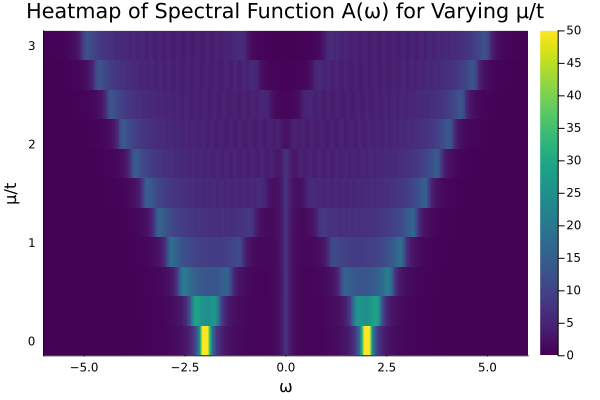

In [14]:
using Plots

function plot_spectral_function_heatmap(omega_range::Vector{Float64}, mu_t_range::Vector{Float64}, spectral_results::Dict{Float64, Tuple{Vector{Float64}, Vector{Float64}}})
    """
    Plots a heatmap of the spectral function A(omega) for varying mu/t values.

    Parameters:
    omega_range     -- Vector of energy values (frequencies)
    mu_t_range      -- Vector of mu/t ratios used in the computation
    spectral_results -- A dictionary containing spectral function values for each mu/t ratio, in the form of tuples (total_A_values, log_total_A_values)
    """

    # Initialize the matrix to store spectral function values for the heatmap
    A_matrix = zeros(length(mu_t_range), length(omega_range))

    # Populate the matrix with spectral function values for each mu/t
    for (i, mu_t) in enumerate(mu_t_range)
        # Extract only the total spectral function values (first element of the tuple) for this mu_t
        A_matrix[i, :] = spectral_results[mu_t][1]
    end

    # Plot the heatmap
    heatmap(
        omega_range, mu_t_range, A_matrix,
        xlabel = "ω",
        ylabel = "μ/t",
        title = "Heatmap of Spectral Function A(ω) for Varying μ/t",
        color = :viridis,
        clims = (0, 50),#maximum(A_matrix)),  # Adjust color limits as necessary
        colorbar = true
    )
end

# Plotting the heatmap using the computed spectral results
plot_spectral_function_heatmap(omega_range, mu_t_range, spectral_results)


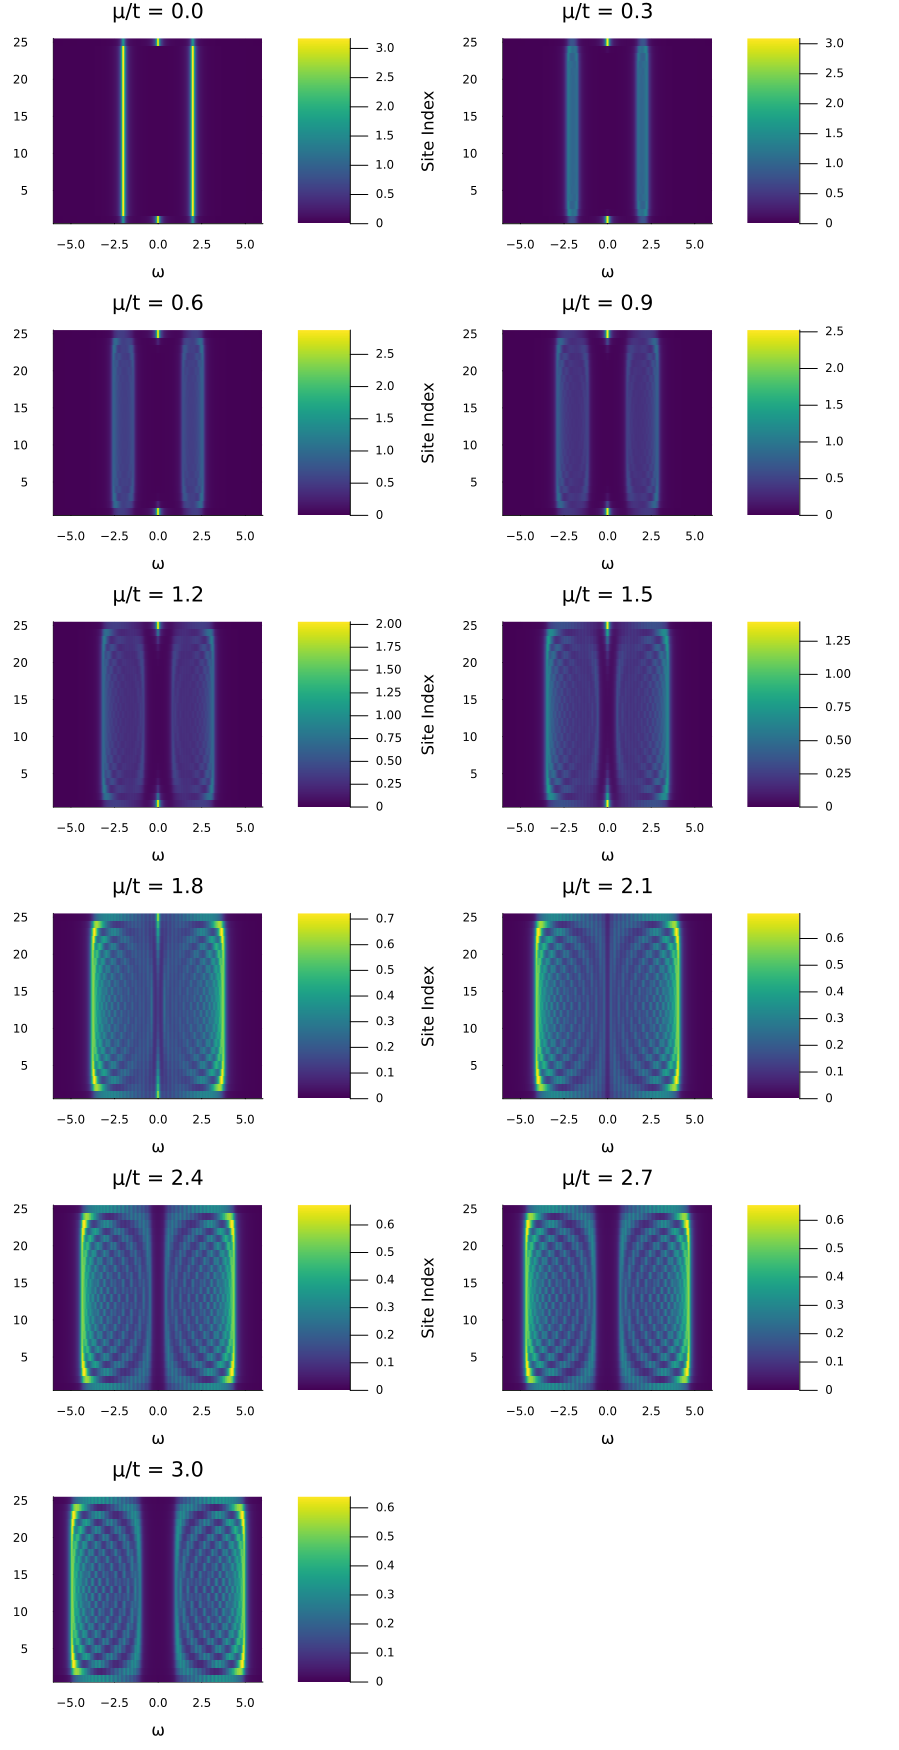

In [19]:
using Plots


# function spectral_function_with_site_index(N::Int, t::Float64, mu::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64})
#     H0 = create_normal_hamiltonian(N, t, mu)
#     pairing_matrix = create_pairing_matrix(N, delta)
#     BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)

#     spectral_values = zeros(N, length(omega_range))

#     for j in 1:length(omega_range)
#         omega = omega_range[j]
#         G = inv((omega + im * eta) .* I - BdG)
#         for i in 1:N
#             spectral_values[i, j] = -imag(G[i, i]) / π
#         end
#     end

#     return spectral_values
# end


function spectral_function_with_site_index(N::Int, t::Float64, mu::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64})
    H0 = create_normal_hamiltonian(N, t, mu)
    pairing_matrix = create_pairing_matrix(N, delta)
    BdG = create_bdg_hamiltonian(N, H0, pairing_matrix)

    spectral_values = zeros(N, length(omega_range))

    for j in 1:length(omega_range)
        omega = omega_range[j]

        G = inv((omega + im * eta) * I - BdG)

        # Separate particle and hole contributions
        for i in 1:N
            particle_contribution = -imag(G[i, i]) / π
            hole_contribution = -imag(G[N + i, N + i]) / π
            spectral_values[i, j] = particle_contribution + hole_contribution
        end
    end

    return spectral_values
end



function compute_spectral_function_with_sites(N::Int, t::Float64, delta::Float64, eta::Float64, omega_range::Vector{Float64}, mu_t_range::Vector{Float64})
    results = Dict{Float64, Matrix{Float64}}()

    for mu_t in mu_t_range
        mu = mu_t * t
        spectral_values = spectral_function_with_site_index(N, t, mu, delta, eta, omega_range)
        results[mu_t] = spectral_values
    end

    return results
end

# # Usage
# omega_range = collect(range(-6.0, 6.0, length=600))
# mu_t_range = collect(range(0.0, 3.0, length=3))

# Compute the spectral function over sites for each mu/t ratio
spectral_results_1 = compute_spectral_function_with_sites(N, t, delta, eta, omega_range, mu_t_range)
# println(spectral_results_1)

# Plotting Function
function plot_spectral_function_site_index_heatmap(omega_range::Vector{Float64}, spectral_results::Dict{Float64, Matrix{Float64}}, mu_t_value::Float64)
    spectral_data = spectral_results[mu_t_value]
    site_indices = 1:size(spectral_data, 1)

    heatmap(omega_range, site_indices, spectral_data,
            xlabel="ω",
            ylabel="Site Index",
            title="Spectral Function A(ω) Heatmap for μ/t = $mu_t_value",
            color=:viridis,
            clims = (0, maximum(spectral_data)),
            colorbar=true
    )
end


# mu_t_value = 1.5
# plot_spectral_function_site_index_heatmap(omega_range, spectral_results_1, mu_t_value)



function plot_spectral_function_site_index_heatmaps(omega_range::Vector{Float64}, spectral_results::Dict{Float64, Matrix{Float64}}, mu_t_values::Vector{Float64})
    n_plots = length(mu_t_values)
    
    # Set layout to match the number of mu_t_values
    n_cols = ceil(2)#Int, sqrt(n_plots))
    n_rows = ceil(Int, n_plots / n_cols)
    
    # Create subplot layout
    plot_list = []
    for mu_t_value in mu_t_values
        spectral_data = spectral_results[mu_t_value]
        site_indices = 1:size(spectral_data, 1)
        
        # Generate individual heatmap for each mu/t value
        p = heatmap(omega_range, site_indices, spectral_data,
                    xlabel="ω",
                    ylabel="Site Index",
                    title="μ/t = $mu_t_value",
                    color=:viridis,
                    clims=(0, maximum(spectral_data)),
                    colorbar=true,
                    colorbar_stretch = :vertical)
        push!(plot_list, p)
    end
    
    # Combine all subplots into one overall layout
    Plots.plot(plot_list..., layout=(n_rows, n_cols), size=(900, 1750), colorbar=true, colorbar_stretch = :vertical)#, title="Spectral Function Heatmaps")
end



# function plot_spectral_function_site_index_heatmaps(omega_range::Vector{Float64}, spectral_results::Dict{Float64, Matrix{Float64}}, mu_t_values::Vector{Float64})
#     n_plots = length(mu_t_values)
    
#     n_cols = 2 
#     n_rows = ceil(Int, n_plots / n_cols)
    
#     # Create subplot layout with annotations for individual titles
#     plot_list = []
#     for mu_t_value in mu_t_values
#         spectral_data = spectral_results[mu_t_value]
#         site_indices = 1:size(spectral_data, 1)
        
#         # Generate individual heatmap for each mu/t value
#         p = heatmap(omega_range, site_indices, spectral_data,
#                     xlabel="ω",
#                     ylabel="Site Index",
#                     color=:viridis,
#                     clims=(0, maximum(spectral_data)),
#                     colorbar=false)  # Disable individual color bar

#         # Annotate individual title for each subplot
#         # annotate!(p, (0.5, 1.05, "μ/t = $mu_t_value"), :above)

#         push!(plot_list, p)
#     end
    
#     # Combine all subplots into one overall layout with a shared color bar
#     combined_plot = Plots.plot(plot_list..., layout=(n_rows, n_cols), size=(800, 1750), colorbar=true)
#     # Plots.plot(plot_list..., layout=(n_rows, n_cols), size=(800, 1750), colorbar=false)

#     # Add main title only once
#     plot!(combined_plot, title="Spectral Function Heatmaps")
    
#     # return combined_plot
# end



# Usage

plot_spectral_function_site_index_heatmaps(omega_range, spectral_results_1, mu_t_range)

